In [ ]:
import tensorflow as tf

for device in tf.config.list_physical_devices():
    print(f"Device: {device.name}")

if tf.config.list_physical_devices('GPU'):
    print("GPU is available for TensorFlow.")
else:
    print("TensorFlow will use CPU.")


Device: /physical_device:CPU:0
TensorFlow will use CPU.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import f1_score
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt

In [4]:
df1 = pd.read_csv("C:/Users/Ксения/PycharmProjects/deep_learning/vscode/SQLiV3.csv", encoding='utf-8')[["Sentence", "Label"]]
df2 = pd.read_csv("C:/Users/Ксения/PycharmProjects/deep_learning/vscode/sqli.csv", encoding='utf-16')
df3 = pd.read_csv("C:/Users/Ксения/PycharmProjects/deep_learning/vscode/sqliv2.csv", encoding='utf-16')

In [5]:
# Объединение и очистка
df = pd.concat([df1, df2, df3])
df.dropna(inplace=True)
df = df[(df['Label'] == "0") | (df['Label'] == "1")]
df = df.drop_duplicates(subset='Sentence')
df['Label'] = pd.to_numeric(df['Label'])
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={'Sentence': 'X', 'Label': 'y'}, inplace=True)

In [ ]:
slice_index_1 = int(0.8 * len(df))
slice_index_2 = int(0.9 * len(df))
train_df = df.iloc[:slice_index_1, :]
val_df = df.iloc[slice_index_1:slice_index_2, :]
test_df = df.iloc[slice_index_2:, :]

X_train = train_df['X'].values
y_train = train_df['y'].values
X_val = val_df['X'].values
y_val = val_df['y'].values
X_test = test_df['X'].values
y_test = test_df['y'].values

In [7]:
# Загрузка BERT-токенизатора и модели
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Токенизация данных
def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="tf"
    )

train_encodings = encode_texts(X_train)
val_encodings = encode_texts(X_val)
test_encodings = encode_texts(X_test)

In [ ]:
def build_classifier_model():
    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name="attention_mask")

    # Определяем функцию для вызова модели BERT
    def get_bert_output(inputs):
        input_ids, attention_mask = inputs
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state

    # Указываем output_shape для Lambda слоя
    bert_output = tf.keras.layers.Lambda(get_bert_output, output_shape=(train_encodings["input_ids"].shape[1], 768))([input_ids, attention_mask])

    # Получаем last_hidden_state из результата
    net = bert_output[:, 0, :]  # Используем CLS-токен
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=net)

classifier_model = build_classifier_model()


In [ ]:
print(train_encodings["input_ids"].shape)


(24476, 512)


In [ ]:
# Компиляция
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(name="AUC")]
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), loss=loss, metrics=metrics)


In [ ]:
# Обучение
history = classifier_model.fit(
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y_train,
    validation_data=({"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]}, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5


c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_ids', 'attention_mask']. Received: the structure of inputs={'input_ids': '*', 'attention_mask': '*'}
  warnings.warn(


765/765 ━━━━━━━━━━━━━━━━━━━━ 11820s 15s/step - AUC: 0.6119 - binary_accuracy: 0.6335 - loss: 0.6300 - val_AUC: 0.8528 - val_binary_accuracy: 0.7630 - val_loss: 0.5016
Epoch 2/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 11879s 16s/step - AUC: 0.8336 - binary_accuracy: 0.7679 - loss: 0.4920 - val_AUC: 0.8538 - val_binary_accuracy: 0.7601 - val_loss: 0.4690
Epoch 3/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 11817s 15s/step - AUC: 0.8453 - binary_accuracy: 0.7785 - loss: 0.4703 - val_AUC: 0.8547 - val_binary_accuracy: 0.7774 - val_loss: 0.4595
Epoch 4/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 11933s 16s/step - AUC: 0.8522 - binary_accuracy: 0.7819 - loss: 0.4564 - val_AUC: 0.8565 - val_binary_accuracy: 0.7777 - val_loss: 0.4565
Epoch 5/5
765/765 ━━━━━━━━━━━━━━━━━━━━ 11850s 15s/step - AUC: 0.8473 - binary_accuracy: 0.7769 - loss: 0.4622 - val_AUC: 0.8586 - val_binary_accuracy: 0.7777 - val_loss: 0.4545


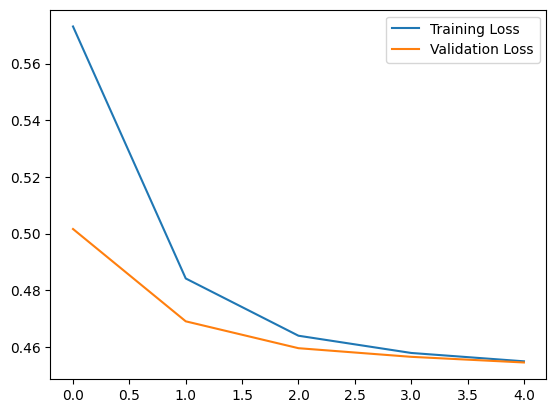

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [14]:
# Оценка на тестовом наборе
test_loss, test_acc, test_auc = classifier_model.evaluate(
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
    y_test
)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1235s 13s/step - AUC: 0.8678 - binary_accuracy: 0.7948 - loss: 0.4384


In [ ]:
y_pred_probs = classifier_model.predict(
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]}
)
y_pred = (y_pred_probs >= 0.5).astype(int)

print(f"Test Accuracy: {test_acc}")
print(f"Test AUC: {test_auc}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 1327s 14s/step
Test Accuracy: 0.7918300628662109
Test AUC: 0.870019793510437
F1 Score: 0.7121554450971532
